# Clairvoyante (Model Training Demo)


In [1]:
%matplotlib inline
%pylab inline
import sys
sys.path.append('../')
import numpy as np
import time
import pickle
from random import randrange

Populating the interactive namespace from numpy and matplotlib


In [2]:
#import clairvoyante
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
import clairvoyante.utils_v2 as utils
import clairvoyante.clairvoyante_v2 as cv
import clairvoyante.param as param
from matplotlib import pyplot as plt

/home/mu2047/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mu2047/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mu2047/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mu2047/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


Instructions for updating:
non-resource variables are not supported in the long term


## Train using the chr21+chr22 variants

In [3]:
# Load the preprocessed and compressed tensors into memory
with open("/scratch/mu2047/Project/Clairvoyante/Clairvoyante/training/tensor.bin", "rb") as fh:
    total = pickle.load(fh)
    XArrayCompressed = pickle.load(fh)
    YArrayCompressed = pickle.load(fh)
    posArrayCompressed = pickle.load(fh)

In [4]:
datasetSize = total

In [5]:
print("The size of training dataset: {}".format(total))

The size of training dataset: 280893


In [6]:
def calculateAccuracy(predicted, labels, top2=True, verbose=False):
    
    top1Count = 0
    top2Count = 0
    # Evaluating on bases
    for predictV, annotateV in zip(predicted[0], labels[:,0:4]):
        sortPredictV = predictV.argsort()[::-1]    
        if np.argmax(annotateV) == sortPredictV[0]:
            top1Count += 1
            top2Count += 1
        elif np.argmax(annotateV) == sortPredictV[1]: 
            top2Count += 1
    
    if verbose:
        # Evaluating on zygosity
        zygosityEval = np.zeros((2,2))
        for predictV, annotateV in zip(predicted[1], labels[:,4:6]):
            zygosityEval[np.argmax(annotateV)][np.argmax(predictV)] += 1

        variantTypeEval = np.zeros((4,4))
        for predictV, annotateV in zip(predicted[2], labels[:,6:10]):
            variantTypeEval[np.argmax(annotateV)][np.argmax(predictV)] += 1

        indelLengthEval = np.zeros((6,6))
        for predictV, annotateV in zip(predicted[3], labels[:,10:16]):
            indelLengthEval[np.argmax(annotateV)][np.argmax(predictV)] += 1
    
    return float(top1Count)*100/len(predicted[0]), float(top2Count)*100/len(predicted[0]) 

def plotGraph(losses, t1Acc, t2Acc, name="Training"):
    
#     print(len(losses))
#     print(t1Acc.shape)
#     print(t2Acc.shape)
    
    epochs = np.arange(len(losses))
    plt.figure()
    plt.plot(epochs, losses, label= name + " loss")
    plt.legend()
    plt.savefig(name+" Loss History.jpg")
    
    plt.figure()
    plt.plot(epochs, t1Acc, label= name + " top1 accuracy")
    plt.plot(epochs, t2Acc, label= name + " top2 accuracy")
    plt.legend()
    plt.savefig(name+" Acc History.jpg")

In [7]:
# training the model. The code train on all variants and validate on the first 10% variant sites
def trainingAbstraction(epochs, model, savePath, modelName, initLr, reduceAfter, total, batchSize, threshold, constantLr=True):
    
    numValItems = int(total * 0.1 + 0.499)
    trainingLosses = []
    trainingAccuraciesT1 = []
    trainingAccuraciesT2 = []
    validationLosses = []
    validationAccuraciesT1 = []
    validationAccuraciesT2 = []
    bestValAcc = 0
    numBatches = total // trainBatchSize
    valXArray, _, _ = utils.DecompressArray(XArrayCompressed, 0, numValItems, total)
    valYArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, numValItems, total)
    print("Number of variants for validation: %d" % len(valXArray))

    trainingStart = time.time()
    
    print("Start at learning rate: %.2e" % m.setLearningRate(initLr))
    
    for currentEpoch in range(epochs):
        epochStartTime = time.time()
        epochTrainingLoss = 0
        epochValidationLoss = 0
        datasetPtr = 0
        
        trainingBase = [] 
        trainingZ = []
        trainingT = [] 
        trainingL = []
        trainingLabels = np.empty((trainBatchSize, 16), dtype=float)

        testingBase = [] 
        testingZ = []
        testingT = [] 
        testingL = []

        if currentEpoch % reduceAfter == 0 and not constantLr:
            m.setLearningRate()


        for batch in range(numBatches):
            # Fetching data from compressed arrays in the tensor.bin file
            XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, trainBatchSize, total)
            YBatch, _, _ = utils.DecompressArray(YArrayCompressed, datasetPtr, trainBatchSize, total)
            epochTrainingLoss += m.train(XBatch, YBatch)[0]/trainBatchSize
            trainPredObject = m.predict(XBatch)
            trainingBase.append(trainPredObject[0])
            trainingZ.append(trainPredObject[1])
            trainingT.append(trainPredObject[2])
            trainingL.append(trainPredObject[3])
            datasetPtr += trainBatchSize


        trainingBase = np.concatenate(trainingBase[:])
        trainingZ = np.concatenate(trainingZ[:])
        trainingT = np.concatenate(trainingT[:])
        trainingL = np.concatenate(trainingL[:])

        trainingLosses.append(float(epochTrainingLoss)/numBatches)
        trainingLabels, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)    
        epochTrainingAccuracies = calculateAccuracy((trainingBase, trainingZ, trainingT, trainingL), trainingLabels)
        trainingAccuraciesT1.append(epochTrainingAccuracies[0]/100)
        trainingAccuraciesT2.append(epochTrainingAccuracies[1]/100)

        epochValidationLoss = m.getLoss(valXArray, valYArray)
        validationLosses.append(epochValidationLoss)
        validationBase, validationZ, validationT, validationL = m.predict(valXArray)
        epochValidationAccuracies = calculateAccuracy((validationBase, validationZ, validationT, validationL), valYArray)
        validationAccuraciesT1.append(epochValidationAccuracies[0]/100)
        validationAccuraciesT2.append(epochValidationAccuracies[1]/100)

        if bestValAcc < epochTrainingAccuracies[0]:
            bestValAcc = epochValidationAccuracies[0]
#             print("Saving new model")
            m.saveParameters(savePath + modelName)

        epochEndTime = time.time()
        print("|".join(
            [
            f"Epoch: {currentEpoch+1}",
            "EpochTime: %.2fs" % (epochEndTime - epochStartTime),
            "TrainingLoss: %.2f" % float(epochTrainingLoss/numBatches),
            "TrainingAccuracy:%2.3f, %2.3f" % epochTrainingAccuracies,
            "ValidationLoss: %.2f" % float(epochValidationLoss/numValItems),
            "ValidationAccuracy:%2.3f, %2.3f" % epochValidationAccuracies, 
            ]))
        
        if epochValidationAccuracies[0] > threshold:
            print("TTA 92: %.2fs"%(time.time() - trainingStart))
            break
    
    return trainingLosses, trainingAccuraciesT1, trainingAccuraciesT2, validationLosses, validationAccuraciesT1, validationAccuraciesT2
    

In [8]:
# create a Clairvoyante network
m = cv.Clairvoyante()
m.init()
trainBatchSize = 2048
epochs = 100
savePath = "./savedModels/"
modelName = "ReduceAfter10LR,initLR=0.003"
reduceAfter = 10 
initLr = 0.003
t1Threshold = 92

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


../clairvoyante/clairvoyante_v2.py:49: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv1 = tf.compat.v1.layers.conv2d(inputs=XPH,
../clairvoyante/clairvoyante_v2.py:58: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  pool1 = tf.compat.v1.layers.max_pooling2d(inputs=conv1,
../clairvoyante/clairvoyante_v2.py:64: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv2 = tf.compat.v1.layers.conv2d(inputs=pool1,
../clairvoyante/clairvoyante_v2.py:73: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  pool2 = tf.compat.v1.layers.max_pooling2d(inputs=conv2,
../clairvoyante/clairvoyante_v2.py:79: UserWarning: `tf.layers.conv2d` is 

In [9]:
returnObject = trainingAbstraction(epochs, m, savePath, modelName, initLr, reduceAfter, datasetSize, trainBatchSize, t1Threshold)

Number of variants for validation: 28089
Start at learning rate: 3.00e-03
Epoch: 1|EpochTime: 23.02s|TrainingLoss: 2.14|TrainingAccuracy:31.351, 57.418|ValidationLoss: 0.86|ValidationAccuracy:40.785, 69.768
Epoch: 2|EpochTime: 22.29s|TrainingLoss: 0.73|TrainingAccuracy:47.670, 77.390|ValidationLoss: 0.61|ValidationAccuracy:52.035, 83.292
Epoch: 3|EpochTime: 22.39s|TrainingLoss: 0.58|TrainingAccuracy:52.799, 86.568|ValidationLoss: 0.54|ValidationAccuracy:55.224, 89.693
Epoch: 4|EpochTime: 22.12s|TrainingLoss: 0.52|TrainingAccuracy:57.326, 90.541|ValidationLoss: 0.48|ValidationAccuracy:58.247, 92.328
Epoch: 5|EpochTime: 22.06s|TrainingLoss: 0.47|TrainingAccuracy:62.603, 93.093|ValidationLoss: 0.43|ValidationAccuracy:67.226, 94.678
Epoch: 6|EpochTime: 21.95s|TrainingLoss: 0.41|TrainingAccuracy:68.043, 95.142|ValidationLoss: 0.36|ValidationAccuracy:73.310, 96.048
Epoch: 7|EpochTime: 21.69s|TrainingLoss: 0.30|TrainingAccuracy:72.350, 96.224|ValidationLoss: 0.23|ValidationAccuracy:78.070, 96

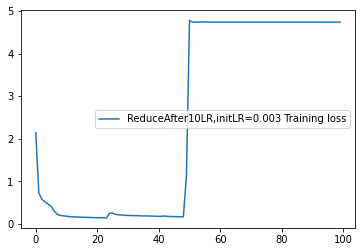

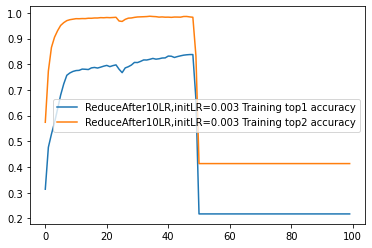

In [10]:
plotGraph(returnObject[0], returnObject[1], returnObject[2], modelName + " Training")

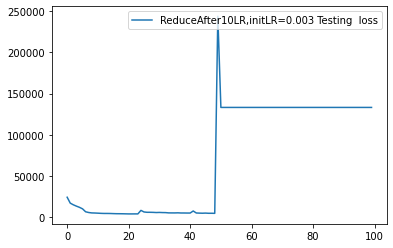

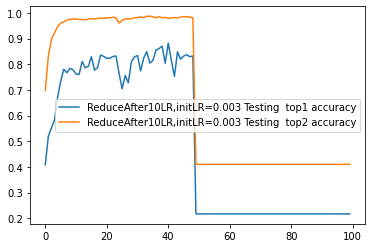

In [11]:
plotGraph(returnObject[3], returnObject[4], returnObject[5], modelName + " Testing ")

In [12]:
trainingBase.shape, trainingZ.shape, trainingT.shape, trainingL.shape 

NameError: name 'trainingBase' is not defined

## Testing on the training dataset

## Testing on the chr22 variants

In [ ]:
total, XArrayCompressed, YArrayCompressed, posArrayCompressed = \
utils.GetTrainingArray("/scratch/mu2047/Project/Clairvoyante/Clairvoyante/training/tensor_can_mix_sampled",
                       "/scratch/mu2047/Project/Clairvoyante/Clairvoyante/training/var_mul_sampled",
                       "/scratch/mu2047/Project/Clairvoyante/Clairvoyante/training/bed")
YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)

In [ ]:
print("Testing on the training and validation dataset ...")
predictStart = time.time()
predictBatchSize = param.predictBatchSize
datasetPtr = 0
XBatch, _, _ = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
print(XBatch.shape)
bases = []; zs = []; ts = []; ls = []
base, z, t, l = m.predict(XBatch)
bases.append(base); zs.append(z); ts.append(t); ls.append(l)
datasetPtr += predictBatchSize
while datasetPtr < total:
    XBatch, _, endFlag = utils.DecompressArray(XArrayCompressed, datasetPtr, predictBatchSize, total)
    base, z, t, l = m.predict(XBatch)
    bases.append(base); zs.append(z); ts.append(t); ls.append(l)
    datasetPtr += predictBatchSize
    if endFlag != 0:
        break
bases = np.concatenate(bases[:]); zs = np.concatenate(zs[:]); ts = np.concatenate(ts[:]); ls = np.concatenate(ls[:])
print("Prediciton time elapsed: %.2f s" % (time.time() - predictStart))

# Evaluate the trained model
YArray, _, _ = utils.DecompressArray(YArrayCompressed, 0, total, total)
print("Version 2 model, evaluation on base change:")
allBaseCount = top1Count = top2Count = 0
for predictV, annotateV in zip(bases, YArray[:,0:4]):
    allBaseCount += 1
    sortPredictV = predictV.argsort()[::-1]
    if np.argmax(annotateV) == sortPredictV[0]: top1Count += 1; top2Count += 1
    elif np.argmax(annotateV) == sortPredictV[1]: top2Count += 1
print("all/top1/top2/top1p/top2p: %d/%d/%d/%.2f/%.2f" %\
            (allBaseCount, top1Count, top2Count, float(top1Count)/allBaseCount*100, float(top2Count)/allBaseCount*100))
print("Version 2 model, evaluation on Zygosity:")
ed = np.zeros( (2,2))
for predictV, annotateV in zip(zs, YArray[:,4:6]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(2):
    print("\t".join([str(ed[i][j]) for j in range(2)]))
print("Version 2 model, evaluation on variant type:")
ed = np.zeros( (4,4))
for predictV, annotateV in zip(ts, YArray[:,6:10]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(4):
    print("\t".join([str(ed[i][j]) for j in range(4)]))
print("Version 2 model, evaluation on indel length:")
ed = np.zeros( (6,6) )
for predictV, annotateV in zip(ls, YArray[:,10:16]):
    ed[np.argmax(annotateV)][np.argmax(predictV)] += 1
for i in range(6):
    print("\t".join([str(ed[i][j]) for j in range(6)]))

## Visualizing predictions

In [ ]:
# Compare the output of the expected calls and the predicted calls
arrayStart = 0
arrayEnd = 100
figure(figsize=(20, 5))
matshow(YArray[arrayStart:arrayEnd,:].transpose(), fignum=0, cmap=cm.PuRd)
figure(figsize=(20, 5))
matshow(np.concatenate( (bases[arrayStart:arrayEnd,:],zs[arrayStart:arrayEnd,:],\
                         ts[arrayStart:arrayEnd,:],ls[arrayStart:arrayEnd,:]),1).transpose(), fignum=0, cmap=cm.PuRd)